# Map area of objects in tiles

In this notebook, we will segment nuclei in tiles and measure their area. We will then save the resulting area map again as tiles in a zarr file. This strategy can be used to process data that as a whole does not fit in computer memory.

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed [License: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ).

In [2]:
image = imread('../../data/P1_H_C3H_M004_17-cropped.tif')[1]

# for testing purposes, we crop the image even more.
# comment out the following line to run on the whole 5000x2000 pixels
image = image[1000:1500, 1000:1500]

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## Object area maps in tiles
Dask brings built-in support for the zarr file format. We can create dask arrays directly from a zarr file.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

We can apply image processing to this tiled dataset directly.

In [4]:
def area_map(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    print("Processing image of size", image.shape)
    
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    result = cle.pixel_count_map(labels)
    
    print(result.shape)
    
    return np.asarray(result)

## Testing tiled image processing
We should test our area mapping algorithm on a single tile. Actually, in a real scenario, the image processing workflow is developed on individual tiles, e.g. in a notebook like this one. As soon as we are sure that the algorithm works, we can apply it to all tiles.

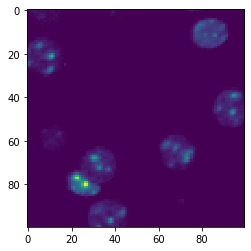

Processing image of size (100, 100)
(100, 100)


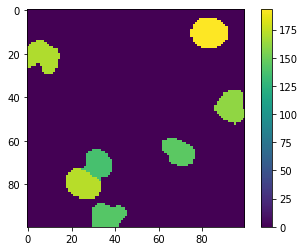

In [5]:
test_image = image[100:200,100:200]

imshow(test_image)

test_result = area_map(test_image)

imshow(test_result, colorbar=True)

## Applying the tiled image processing to a zarr-backed dataset

Applying the function to our zarr dataset will also result in a dask array.

In [6]:
overlap_width = 30

tile_map = da.map_overlap(area_map, zarr_image, depth=overlap_width, boundary=0)

tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
(1, 1)
Processing image of size (0, 0)


dask.array<_trim, shape=(500, 500), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>

Before we can start the computation, we need to deactivate asynchronous execution of operations in pyclesperanto. [See also related issue](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163).

In [7]:
cle.set_wait_for_kernel_finish(True)

When we invoke saving the results to disk, the processing will happen on individual tiles.

In [8]:
processed_zarr_filename = '../../data/P1_H_C3H_M004_17-processed.zarr'

tile_map.to_zarr(processed_zarr_filename, overwrite=True)

Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
Processing image of size Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size(160, 160) 
(160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
(160, 160)Processing image of sizeProcessing image of size(160, 160)
 (160, 160)
 
(160, 1

## Loading zarr
Just for demonstration purposes, we will load the zarr backed tiled image and visualize it. When working with big data, this step might not be possible.

In [9]:
zarr_result = da.from_zarr(processed_zarr_filename)
zarr_result

dask.array<from-zarr, shape=(500, 500), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>

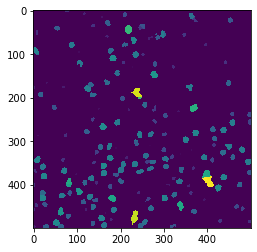

In [10]:
result = zarr_result.compute()

cle.imshow(result)